# 1. Install Dependencies
Install the required libraries for the segmentation pipeline. We use `segmentation-models-pytorch` for the model architectures, `timm` for the pre-trained encoders, and `albumentations` for heavy data augmentation.

In [19]:
from google.colab import drive
drive.mount('/content/drive')

# Unzip it into the Colab environment
!unzip -q "/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install -q segmentation-models-pytorch albumentations timm tqdm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.3 MB/s eta 0:00:00


# 2. Preprocessing & Dataset Pipeline
Define heavy augmentations (CLAHE, Noise, Blur, Color Jitter) to bridge the Synthetic-to-Real gap, and create the PyTorch Dataset.

In [20]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. Define the Heavy Augmentation Pipeline for Training
# This forces the model to ignore synthetic textures and focus on shapes
train_transform = A.Compose([
    # Geometric: Scale invariance and flipping
    A.RandomResizedCrop(size=(512, 512), scale=(0.5, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    
    # Photometric: Lighting, Contrast, and Desert Sun simulation
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.7),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    
    # Artifacts: Camera noise and motion blur from bumpy UGV rides
    A.MotionBlur(blur_limit=5, p=0.3),
    A.GaussNoise(std_range=(0.012, 0.027), p=0.3),
    A.ISONoise(p=0.3),
    
    # Standard Normalization for ImageNet weights
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Validation Pipeline (No crazy augmentations, just resize and normalize)
val_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 2. Define the Dataset Class
class DesertSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.images = sorted(os.listdir(self.image_dir))
        
        # Mapping raw pixel values to class IDs (0 to 9)
        self.value_map = {
            0: 0, 100: 1, 200: 2, 300: 3, 500: 4, 
            550: 5, 700: 6, 800: 7, 7100: 8, 10000: 9
        }

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load Image (Convert BGR to RGB for Albumentations/PyTorch)
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load Mask (Keep unchanged to read raw values like 100, 7100, etc.)
        mask_path = os.path.join(self.masks_dir, img_name)
        raw_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if raw_mask is None:
            raise FileNotFoundError(f"Could not load mask: {mask_path}")
        
        # Convert raw mask values to 0-9 class IDs
        mask = np.zeros_like(raw_mask, dtype=np.int64)
        for raw_val, class_id in self.value_map.items():
            mask[raw_mask == raw_val] = class_id
            
        # Apply Albumentations transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Mask needs to be long tensor for CrossEntropyLoss
        return image, mask.long()

# --- SETUP DATALOADERS ---
# Update these paths if your data is located elsewhere
TRAIN_DIR = 'Offroad_Segmentation_Training_Dataset/train'
VAL_DIR = 'Offroad_Segmentation_Training_Dataset/val'

# Batch size 8 is safe for 16GB T4 GPU with 512x512 images and MiT-B2
train_dataset = DesertSegmentationDataset(TRAIN_DIR, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = DesertSegmentationDataset(VAL_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images.")

Loaded 2857 training images and 317 validation images.


# 3. Model, Loss, Optimizer, and Training Loop
Initialize the SegFormer (MiT-B2) model, set up the CrossEntropy + Dice Loss, and run the training loop using Automatic Mixed Precision (AMP) to train twice as fast and use half the GPU memory.

In [23]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Initialize Model: Unet with SegFormer (MiT-B2) backbone
# Note: UnetPlusPlus does not support mit_b2, so we use standard Unet
model = smp.Unet(
    encoder_name="mit_b2",        # SegFormer backbone (excellent for domain generalization)
    encoder_weights="imagenet",   # Pre-trained on ImageNet
    in_channels=3,                # RGB images
    classes=10                    # 10 classes in your dataset
).to(device)

# 2. Define Hybrid Loss (CrossEntropy + Dice)
# CE handles general classification, Dice forces the model to care about small objects (rocks/logs)
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(smp.losses.MULTICLASS, mode='log_softmax')

def criterion(y_pred, y_true):
    return 0.5 * ce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# 3. Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 4. AMP Scaler for Free GPU Memory Optimization
scaler = torch.cuda.amp.GradScaler()

# 5. Training Loop
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # --- TRAINING ---
    model.train()
    train_loss = 0.0
    
    # tqdm for progress bar
    train_bar = tqdm(train_loader, desc="Training")
    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Forward Pass
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
            
        # Mixed Precision Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = train_loss / len(train_loader)
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device)
            
            # Mixed Precision Forward Pass (saves memory during val too)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step() # Update learning rate
    
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_model.pth")
        print("--> Saved new best model!")

print("\nTraining Complete! Best model saved as 'best_segformer_model.pth'")

# Download the model to your local machine
try:
    from google.colab import files
    files.download("best_segformer_model.pth")
    print("Downloading model to your local machine...")
except ImportError:
    print("Not running in Colab, skipping download.")

Using device: cuda


AttributeError: module 'segmentation_models_pytorch.losses' has no attribute 'MULTICLASS'

In [24]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Initialize Model: Unet with SegFormer (MiT-B2) backbone
# Note: UnetPlusPlus does not support mit_b2, so we use standard Unet
model = smp.Unet(
    encoder_name="mit_b2",        # SegFormer backbone (excellent for domain generalization)
    encoder_weights="imagenet",   # Pre-trained on ImageNet
    in_channels=3,                # RGB images
    classes=10                    # 10 classes in your dataset
).to(device)

# 2. Define Hybrid Loss (CrossEntropy + Dice)
# CE handles general classification, Dice forces the model to care about small objects (rocks/logs)
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass')

def criterion(y_pred, y_true):
    return 0.5 * ce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# 3. Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# 4. AMP Scaler for Free GPU Memory Optimization
scaler = torch.cuda.amp.GradScaler()

# 5. Training Loop
epochs = 20
best_val_loss = float('inf')

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # --- TRAINING ---
    model.train()
    train_loss = 0.0
    
    # tqdm for progress bar
    train_bar = tqdm(train_loader, desc="Training")
    for images, masks in train_bar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Forward Pass
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
            
        # Mixed Precision Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        
    avg_train_loss = train_loss / len(train_loader)
    
    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation")
        for images, masks in val_bar:
            images, masks = images.to(device), masks.to(device)
            
            # Mixed Precision Forward Pass (saves memory during val too)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step() # Update learning rate
    
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_segformer_model.pth")
        print("--> Saved new best model!")

print("\nTraining Complete! Best model saved as 'best_segformer_model.pth'")

# Download the model to your local machine
try:
    from google.colab import files
    files.download("best_segformer_model.pth")
    print("Downloading model to your local machine...")
except ImportError:
    print("Not running in Colab, skipping download.")

Using device: cuda

Epoch 1/20


/tmp/ipython-input-4188079558.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/358 [00:00<?, ?it/s]

/tmp/ipython-input-4188079558.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation:   0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipython-input-4188079558.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.8099 | Val Loss: 0.5396 | LR: 0.000099
--> Saved new best model!

Epoch 2/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.5547 | Val Loss: 0.4496 | LR: 0.000098
--> Saved new best model!

Epoch 3/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4558 | Val Loss: 0.4017 | LR: 0.000095
--> Saved new best model!

Epoch 4/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4271 | Val Loss: 0.3849 | LR: 0.000091
--> Saved new best model!

Epoch 5/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.4059 | Val Loss: 0.3732 | LR: 0.000086
--> Saved new best model!

Epoch 6/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3978 | Val Loss: 0.3652 | LR: 0.000080
--> Saved new best model!

Epoch 7/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3829 | Val Loss: 0.3542 | LR: 0.000073
--> Saved new best model!

Epoch 8/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3742 | Val Loss: 0.3498 | LR: 0.000066
--> Saved new best model!

Epoch 9/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3684 | Val Loss: 0.3444 | LR: 0.000058
--> Saved new best model!

Epoch 10/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3634 | Val Loss: 0.3389 | LR: 0.000051
--> Saved new best model!

Epoch 11/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3431 | Val Loss: 0.3302 | LR: 0.000043
--> Saved new best model!

Epoch 12/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3360 | Val Loss: 0.3267 | LR: 0.000035
--> Saved new best model!

Epoch 13/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3306 | Val Loss: 0.3219 | LR: 0.000028
--> Saved new best model!

Epoch 14/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3290 | Val Loss: 0.3208 | LR: 0.000021
--> Saved new best model!

Epoch 15/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3246 | Val Loss: 0.3180 | LR: 0.000015
--> Saved new best model!

Epoch 16/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3243 | Val Loss: 0.3197 | LR: 0.000010

Epoch 17/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3226 | Val Loss: 0.3159 | LR: 0.000006
--> Saved new best model!

Epoch 18/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3226 | Val Loss: 0.3150 | LR: 0.000003
--> Saved new best model!

Epoch 19/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3239 | Val Loss: 0.3152 | LR: 0.000002

Epoch 20/20


Training:   0%|          | 0/358 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.3206 | Val Loss: 0.3154 | LR: 0.000001

Training Complete! Best model saved as 'best_segformer_model.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Test the Model and Visualize Results
Now that the model is trained, let's load the best saved weights and test it on some images from the validation set to see how well it performs visually.

Unzipping test dataset from Google Drive...
Saved comparison plot to test_results/test_comparison.png


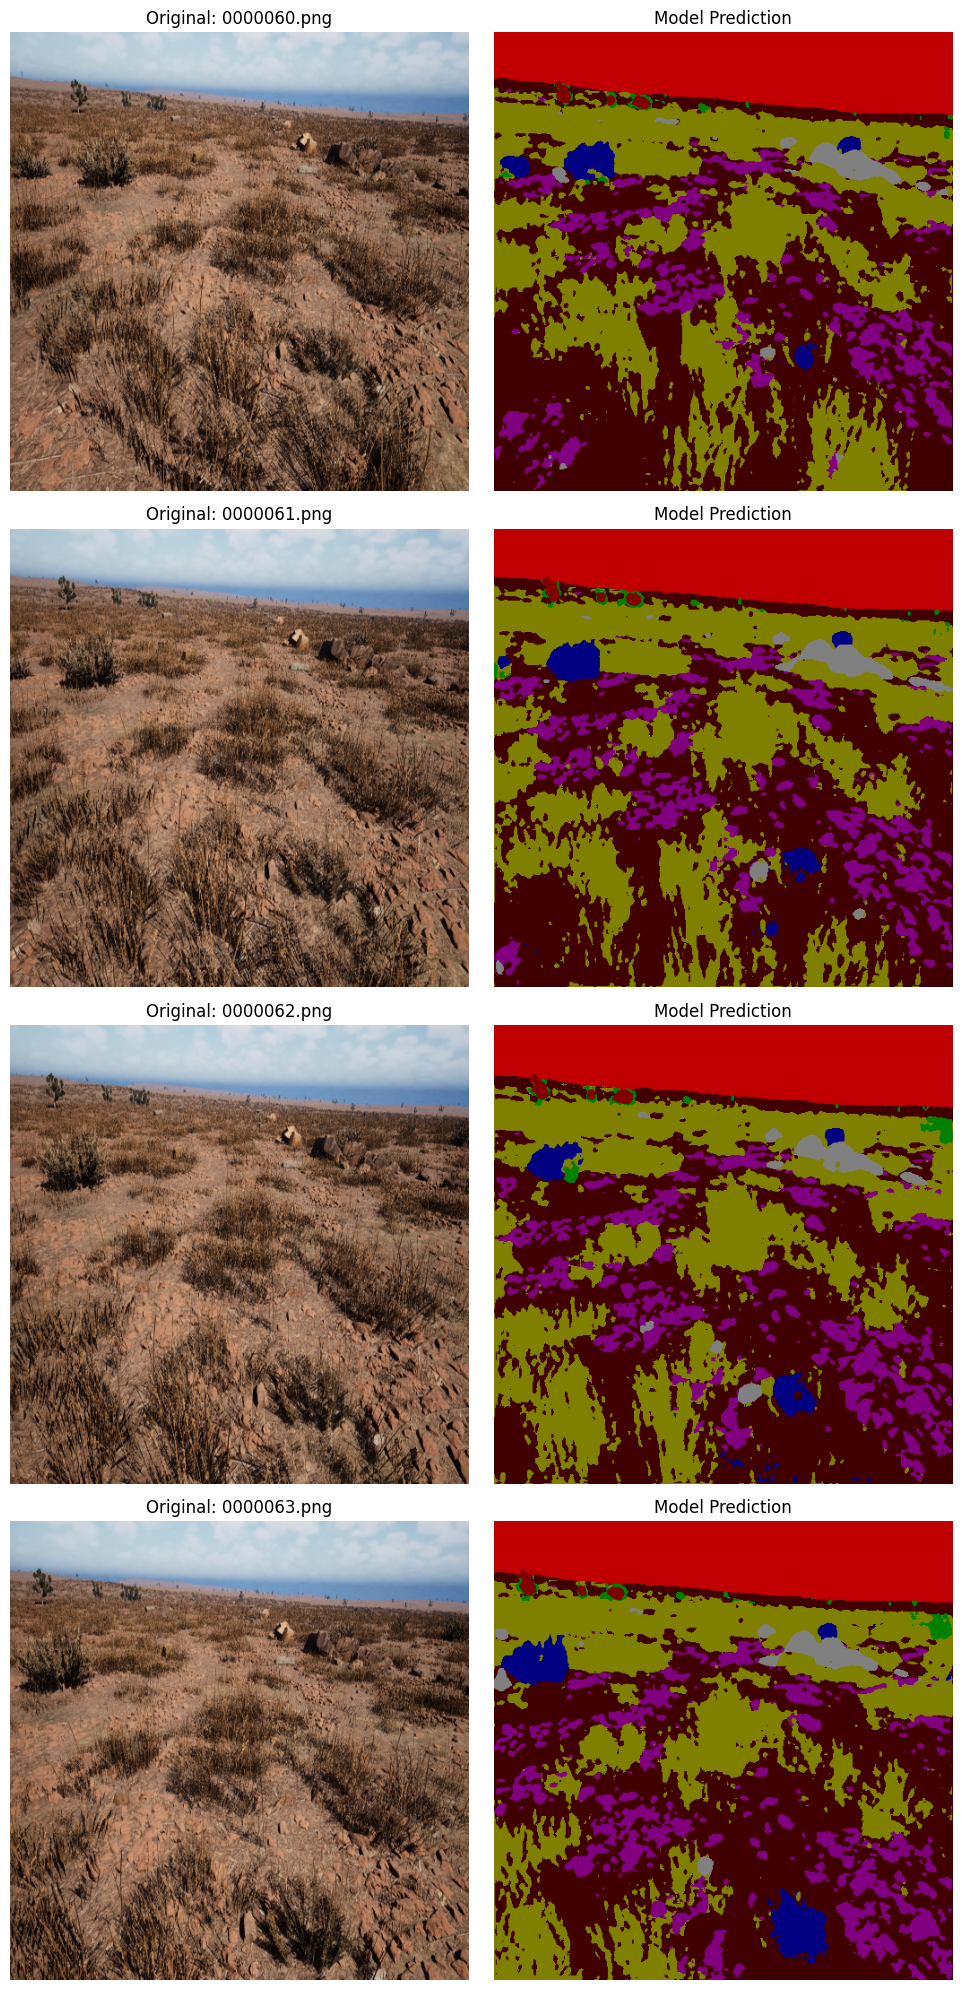

Zipping results and downloading to your local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# --- NEW: Handle Colab Unzipping and Paths ---
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    if not os.path.exists('/content/Offroad_Segmentation_testImages'):
        print("Unzipping test dataset from Google Drive...")
        os.system('unzip -q "/content/drive/MyDrive/Offroad_Segmentation_testImages.zip" -d "/content/"')
    TEST_BASE_DIR = '/content/Offroad_Segmentation_testImages'
else:
    TEST_BASE_DIR = 'Offroad_Segmentation_testImages'

TEST_DIR = os.path.join(TEST_BASE_DIR, 'Color_Images')

# 1. Load the best model weights
model.load_state_dict(torch.load("best_segformer_model.pth"))
model.eval()

# 2. Define a color map for the 10 classes to make the output readable
color_map = np.array([
    [0, 0, 0],         # Class 0: Background (Black)
    [128, 0, 0],       # Class 1: Dark Red
    [0, 128, 0],       # Class 2: Dark Green
    [128, 128, 0],     # Class 3: Olive
    [0, 0, 128],       # Class 4: Navy
    [128, 0, 128],     # Class 5: Purple
    [0, 128, 128],     # Class 6: Teal
    [128, 128, 128],   # Class 7: Gray
    [64, 0, 0],        # Class 8: Maroon
    [192, 0, 0]        # Class 9: Bright Red
])

def decode_segmap(image, nc=10):
    """Converts a 2D array of class IDs into an RGB image."""
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = color_map[l, 0]
        g[idx] = color_map[l, 1]
        b[idx] = color_map[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Create a directory to save the output images
output_dir = "test_results"
os.makedirs(output_dir, exist_ok=True)

# 4. Evaluate and Visualize
if not os.path.exists(TEST_BASE_DIR):
    print(f"❌ Could not find test directory: {TEST_BASE_DIR}")
    print("Please make sure you have uploaded 'Offroad_Segmentation_testImages.zip' to your Google Drive.")
else:
    # --- CALCULATE TEST LOSS ---
    print("Calculating Test Loss over the entire test set...")
    # We reuse the DesertSegmentationDataset and val_transform defined earlier in the notebook
    test_dataset = DesertSegmentationDataset(TEST_BASE_DIR, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
    
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            test_loss += loss.item()
            
    avg_test_loss = test_loss / len(test_loader)
    print(f"✅ Average Test Loss: {avg_test_loss:.4f}\n")

    # --- VISUALIZE RESULTS ---
    print("Generating visualizations for the first 4 images...")
    test_images = sorted(os.listdir(TEST_DIR))[:4] # Let's test on the first 4 images
    
    fig, axes = plt.subplots(len(test_images), 2, figsize=(10, 5 * len(test_images)))
    
    for i, img_name in enumerate(test_images):
        img_path = os.path.join(TEST_DIR, img_name)
        
        # Load and prepare the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_image = image.copy() # Keep a copy for visualization
        
        # Apply transforms (using val_transform to match evaluation)
        augmented = val_transform(image=image)
        input_tensor = augmented['image'].unsqueeze(0).to(device) # Add batch dimension
        
        # Run inference
        with torch.no_grad():
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            
        # Decode mask to RGB
        pred_rgb = decode_segmap(pred_mask)
        
        # Resize original image to match the 512x512 prediction for plotting
        original_resized = cv2.resize(original_image, (512, 512))
        
        # Plotting
        axes[i, 0].imshow(original_resized)
        axes[i, 0].set_title(f"Original: {img_name}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred_rgb)
        axes[i, 1].set_title("Model Prediction")
        axes[i, 1].axis('off')
        
        # Save individual prediction
        save_path = os.path.join(output_dir, f"pred_{img_name}")
        # Convert RGB back to BGR for OpenCV saving
        cv2.imwrite(save_path, cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR))

    plt.tight_layout()
    
    # Save the combined plot
    plot_path = os.path.join(output_dir, "test_comparison.png")
    plt.savefig(plot_path)
    print(f"Saved comparison plot to {plot_path}")
    plt.show()

    # Zip the results folder and download it
    if IN_COLAB:
        from google.colab import files
        print("Zipping results and downloading to your local machine...")
        os.system(f'zip -r {output_dir}.zip {output_dir}')
        files.download(f"{output_dir}.zip")